In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt

### From Darksky

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains
import time
import datetime

### Find UV

In [31]:
def get_wind(driver,lat,lon,dat,ticks):
    driver.get(f'https://darksky.net/details/{lat},{lon}/{dat}/us12/en')
    wind = []
    for tick in ticks:
        hour = driver.find_element_by_xpath(f'//span[{tick}]')
        ActionChains(driver).move_to_element(hour).click(hour).perform()
        nums = driver.find_elements_by_class_name('num')
        try:
            wind.append(int(nums[5].text))  # use 3 for wind, 5 for humidity
        except:
            if len(wind) >= 1:
                wind.append(wind[-1])
            else:
                wind.append(50)
    return wind

In [32]:
ticks1 = [
    '@class="even first" and @style="left: 0px;"',
    '@class="odd second" and @style="left: 33.3333px;"',
    '@class="even" and @style="left: 66.6667px;"',
    '@class="odd" and @style="left: 100px;"',
    '@class="even" and @style="left: 133.333px;"',
    '@class="odd" and @style="left: 166.667px;"',
    '@class="even" and @style="left: 200px;"',
    '@class="odd" and @style="left: 233.333px;"',
    '@class="even" and @style="left: 266.667px;"',
    '@class="odd" and @style="left: 300px;"',
    '@class="even" and @style="left: 333.333px;"',
    '@class="odd" and @style="left: 366.667px;"',
    '@class="even" and @style="left: 400px;"',
    '@class="odd" and @style="left: 433.333px;"',
    '@class="even" and @style="left: 466.667px;"',
    '@class="odd" and @style="left: 500px;"',
    '@class="even" and @style="left: 533.333px;"',
    '@class="odd" and @style="left: 566.667px;"',
    '@class="even" and @style="left: 600px;"',
    '@class="odd" and @style="left: 633.333px;"',
    '@class="even" and @style="left: 666.667px;"',
    '@class="odd" and @style="left: 700px;"',
    '@class="even" and @style="left: 733.333px;"',
    '@class="odd" and @style="left: 766.667px;"',
]

In [33]:
ticks2 = [
    '@class="even first" and @style="left: 0px;"',
    '@class="odd second" and @style="left: 34.7826px;"',
    '@class="even" and @style="left: 69.5652px;"',
    '@class="odd" and @style="left: 104.348px;"',
    '@class="even" and @style="left: 139.13px;"',
    '@class="odd" and @style="left: 173.913px;"',
    '@class="even" and @style="left: 208.696px;"',
    '@class="odd" and @style="left: 243.478px;"',
    '@class="even" and @style="left: 278.261px;"',
    '@class="odd" and @style="left: 313.043px;"',
    '@class="even" and @style="left: 347.826px;"',
    '@class="odd" and @style="left: 382.609px;"',
    '@class="even" and @style="left: 417.391px;"',
    '@class="odd" and @style="left: 452.174px;"',
    '@class="even" and @style="left: 486.957px;"',
    '@class="odd" and @style="left: 521.739px;"',
    '@class="even" and @style="left: 556.522px;"',
    '@class="odd" and @style="left: 591.304px;"',
    '@class="even" and @style="left: 626.087px;"',
    '@class="odd" and @style="left: 660.87px;"',
    '@class="even" and @style="left: 695.652px;"',
    '@class="odd" and @style="left: 730.435px;"',
    '@class="even" and @style="left: 765.217px;"',
]

### Get clustered solar plant weather data

In [34]:
plants = pd.read_csv('datasets/wind_clusters.csv')
print(plants.shape)
plants.head()

(7, 3)


,Longitude,Latitude,MW
0,-118.320799,35.062432,3526.14
1,-121.736003,37.920458,1657.66
2,-116.606149,33.918124,687.85
3,-112.935725,38.571090,304.00
4,-105.461670,34.651112,298.20


In [47]:
early_date = '10/15/2019'
later_date = '04/14/2020'

dates = pd.date_range(early_date, later_date).tolist()
dates = [date.strftime("%Y-%m-%d") for date in dates]

In [48]:
#### PRINT INITIAL TIME STAMP ######
ts1 = time.time()
st1 = datetime.datetime.fromtimestamp(ts1).strftime('%Y-%m-%d %H:%M:%S')
print(st1)


driver = webdriver.Chrome(ChromeDriverManager().install())

df_list = []

for i in range(plants.shape[0]):
    pid = plants.index[i]
    lat = plants['Latitude'][i]
    lon = plants['Longitude'][i]
    
    wind_list = []
    hr_list = []
    
    for date in dates:
        try:
            nu_wind = get_wind(driver,str(lat),str(lon),date,ticks1)
            hours = pd.date_range(start=date+' 00:00:00',end=date+' 23:00:00', periods=24)
            wind_list.extend(nu_wind)
            hr_list.extend(hours)
        except:
            try:
            
                time.sleep(5)
                nu_wind = get_wind(driver,str(lat),str(lon),date,ticks1)
                hours = pd.date_range(start=date+' 00:00:00',end=date+' 23:00:00', periods=24)
                wind_list.extend(nu_wind)
                hr_list.extend(hours)
            
            except:
            
                time.sleep(5)
                nu_wind = get_wind(driver,str(lat),str(lon),date,ticks2)
                hours = pd.date_range(start=date+' 01:00:00',end=date+' 23:00:00', periods=23)
                wind_list.extend(nu_wind)
                hr_list.extend(hours)
            
    nu_df = pd.DataFrame({'date':hr_list,pid:wind_list})

    if i == 0:
        all_df = nu_df.copy()
    else:
        all_df = all_df.merge(nu_df,how='outer',on='date')

##### PRINT FINAL TIME STAMP #######
ts2 = time.time()
st2 = datetime.datetime.fromtimestamp(ts2).strftime('%Y-%m-%d %H:%M:%S')
print(st2)
print('t(s) = ' + str(ts2-ts1))
print('t(m) = ' + str((ts2-ts1)/60))

[WDM] - Cache is valid for [04/06/2020]
[WDM] - Looking for [chromedriver 83.0.4103.39 mac64] driver in cache 
[WDM] - Driver found in cache [/Users/Sam/.wdm/drivers/chromedriver/83.0.4103.39/mac64/chromedriver]


2020-06-04 01:30:56
 
2020-06-04 06:34:32
t(s) = 18215.891836166382
t(m) = 303.5981972694397


In [46]:
len(hr_list)-len(wind_list)

-46

(4391, 8)


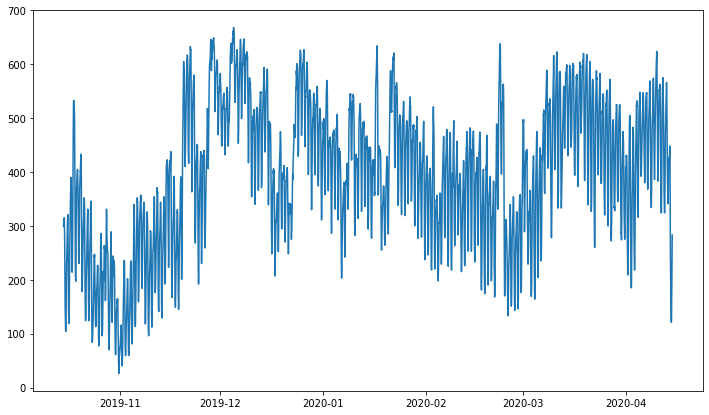

In [49]:
print(all_df.shape)
plt.figure(figsize=(12,7))
plt.plot(all_df['date'],all_df.sum(axis=1))

### Combine plant capacity with wind speed

In [50]:
all_df.to_csv('datasets/time_series/cluster_windspeed2.csv',index=False)

In [17]:
all_df.head()

,date,0,1,2,3,4,5,6
0,2020-03-15 00:00:00,8,7,11,14,7,5,14
1,2020-03-15 01:00:00,8,7,14,14,7,3,15
2,2020-03-15 02:00:00,7,7,13,14,6,3,15
3,2020-03-15 03:00:00,9,7,8,14,5,3,15
4,2020-03-15 04:00:00,6,8,15,14,5,3,15


In [18]:
wind_output = all_df.copy()

for col in all_df.columns:
    if col != 'date':
        wind_output[col] = all_df[col]*plants['MW'][int(col)]

In [20]:
wind_output.to_csv('datasets/time_series/wind_cluster.csv',index=False)

In [108]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get('https://darksky.net/details/35.5912,-115.427/2020-7-2/us12/en')

wind = []
uv = []

for tick in ticks:
    hour = driver.find_element_by_xpath(f'//span[{tick}]')
    ActionChains(driver).move_to_element(hour).click(hour).perform()
    nums = driver.find_elements_by_class_name('num')
    try:
        wind.append(int(nums[3].text))
    except:
        wind.append(0)

[WDM] - Cache is valid for [03/06/2020]
[WDM] - Looking for [chromedriver 83.0.4103.39 mac64] driver in cache 
[WDM] - Driver found in cache [/Users/Sam/.wdm/drivers/chromedriver/83.0.4103.39/mac64/chromedriver]


NameError: name 'ticks' is not defined

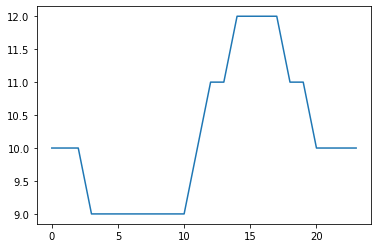

In [5]:
plt.plot(wind)

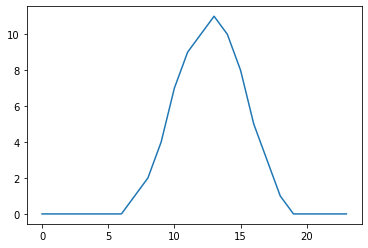

In [6]:
plt.plot(uv)

In [7]:
len(uv)

24

In [57]:
solar[solar['MW']>=20]['MW'].sum()/solar['MW'].sum()

0.8578307578326047